In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile
from scipy.signal import argrelextrema
import os

import sys
sys.path.append('../../')
from cad.calc.geo import Geo
from cad.calc.conv import freq_to_note_and_cent, note_name
import pandas as pd
import seaborn as sns


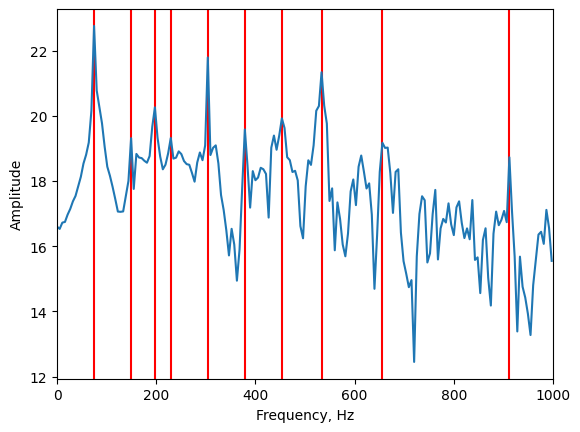

'{"note": {"0": "D1", "7": "D2", "3": "G2", "6": "A#3", "1": "D#3", "5": "F#3", "4": "A#4", "2": "C4", "8": "E4", "9": "A#5"}, "cent-diff": {"0": -29.186907488181646, "7": -29.186907488181646, "3": -11.705039773796244, "6": 28.121293338425346, "1": 40.170981983253284, "5": -40.057544424674774, "4": 48.36987561570183, "2": -32.98842874872534, "8": 8.621592573854997, "9": 38.215981117865994}, "freq": {"0": 74.66440923932761, "7": 149.32881847865522, "3": 197.32736727536582, "6": 229.32639980650623, "1": 303.9908090458338, "5": 378.6552182851614, "4": 453.319627524489, "2": 533.3172088523401, "8": 655.9801668883782, "9": 911.9724271375014}, "impedance": {"0": 7077269.224123592, "7": 651051.9652029042, "3": 1254565.572641898, "6": 653668.1255613645, "1": 3621993.552801448, "5": 783622.9325813947, "4": 991882.236723337, "2": 2645503.3839946836, "8": 590509.1527637121, "9": 433782.7710599926}}'

In [7]:
# analyze peaks from the record

def do_fft(infile, size=-1, maxfreq=1000):
    sampFreq, sound = wavfile.read(infile)
    
    if len(sound.shape)==2:
        signal = sound[:,0]
    else:
        signal = sound

    if size == -1:
        size=len(signal)
    
    fft_spectrum = np.fft.rfft(signal, n=size)
    freq = np.fft.rfftfreq(size, d=1./sampFreq)
    fft_spectrum_abs = np.abs(fft_spectrum)
 
    i=0
    while i<len(freq) and freq[i]<=maxfreq:
        i+=1
    freq = freq[0:i]
    fft_spectrum_abs = fft_spectrum_abs[0:i]

    return freq, fft_spectrum_abs

# get peaks in fft
def get_n_peaks(freq, spectrum, n=10):
    # get all maxima
    peaks = []
    rising = True
    
    for i in range(1,len(spectrum)):
        if spectrum[i]<spectrum[i-1] and rising:
            rising = False
            peaks.append(i-1)
        if spectrum[i]>spectrum[i-1]:
            rising = True
            
    # get n highest maxima
    peaks = sorted(peaks, key=lambda x : spectrum[x], reverse=True)
    df = []
    for i in range(n):
        f = freq[peaks[i]]
        note, cent = freq_to_note_and_cent(f)
        imp = spectrum[peaks[i]]
        
        skip = False
        for j in range(len(df)):
            if np.abs(np.log2(df[j][2])-np.log2(f))<0.15:
                if imp>df[j][3]:
                    del df[j]
                    break
                else:
                    skip = True
                    break
        
        if not skip:
            df.append([note_name(note), cent, f, imp])
    
    df = pd.DataFrame(df, columns=["note", "cent-diff", "freq", "impedance"])
    
    
    
    return df
infile = "tamaki/tamaki_vorlage_short.wav"
freq, spectrum = do_fft(infile)
maxima = get_n_peaks(freq, spectrum, n=20).sort_values(by=["freq"])
maxima
spectrum = np.log2(spectrum)

for m in maxima.freq:
    plt.axvline(x=m, color="red")

plt.plot(freq, spectrum, label="sound")

plt.xlim((0,1000))

plt.xlabel("Frequency, Hz")
plt.ylabel("Amplitude")
plt.show()

maxima.to_csv("maxima_4.csv")

import json
json.dumps(maxima.to_dict())

In [8]:
maxima

,note,cent-diff,freq,impedance
0,D1,-29.186907,74.664409,7.077269e+06
7,D2,-29.186907,149.328818,6.510520e+05
3,G2,-11.705040,197.327367,1.254566e+06
6,A#3,28.121293,229.326400,6.536681e+05
1,D#3,40.170982,303.990809,3.621994e+06
5,F#3,-40.057544,378.655218,7.836229e+05
4,A#4,48.369876,453.319628,9.918822e+05
2,C4,-32.988429,533.317209,2.645503e+06
8,E4,8.621593,655.980167,5.905092e+05
9,A#5,38.215981,911.972427,4.337828e+05


In [5]:
# loss function

from cad.calc.loss import LossFunction

class TamakiLoss(LossFunction):

    def __init__(self):
        self.reference = '{"note": {"0": "D1", "7": "D2", "3": "G2", "6": "A#3", "1": "D#3", "5": "F#3", "4": "A#4", "2": "C4", "8": "E4", "9": "A#5"}, "cent-diff": {"0": -29.186907488181646, "7": -29.186907488181646, "3": -11.705039773796244, "6": 28.121293338425346, "1": 40.170981983253284, "5": -40.057544424674774, "4": 48.36987561570183, "2": -32.98842874872534, "8": 8.621592573854997, "9": 38.215981117865994}, "freq": {"0": 74.66440923932761, "7": 149.32881847865522, "3": 197.32736727536582, "6": 229.32639980650623, "1": 303.9908090458338, "5": 378.6552182851614, "4": 453.319627524489, "2": 533.3172088523401, "8": 655.9801668883782, "9": 911.9724271375014}, "impedance": {"0": 7077269.224123592, "7": 651051.9652029042, "3": 1254565.572641898, "6": 653668.1255613645, "1": 3621993.552801448, "5": 783622.9325813947, "4": 991882.236723337, "2": 2645503.3839946836, "8": 590509.1527637121, "9": 433782.7710599926}}'
        self.reference = pd.DataFrame(json.loads(self.reference))        
        self.reference["impedance_normalized"] = self.reference.impedance / self.reference.impedance.max()
        self.reference["logfreq"] = np.log2(self.reference.freq)
        
    def get_loss(self, geo):
        peaks = geo.get_cadsd().get_notes()
        peaks["logfreq"] = np.log2(peaks.freq)
        peaks["impedance_normalized"] = peaks.impedance / peaks.impedance.max()
        
        tuning_loss = []
        imp_loss = []
        for ix, peak in peaks.iterrows():
            mini = np.argmin([np.abs(peak.logfreq-f) for f in self.reference.logfreq])
            
            tl = np.abs(peak.logfreq-self.reference.logfreq[mini])
            il = np.abs(peak.impedance_normalized - self.reference.impedance_normalized[mini])
            tuning_loss.append(tl)
            imp_loss.append(il)
            # print(f"{self.reference.freq[mini]:.0f}, {peak.freq:.0f}, {tl:.2f}, {il:.2f}")

        fundamental_loss = tuning_loss[0]*10
        tuning_loss = np.sum(tuning_loss)
        imp_loss = np.sum(imp_loss)
        
        return {
            "loss": fundamental_loss + tuning_loss + imp_loss,
            "fundamental_loss": fundamental_loss,
            "tuning_loss": tuning_loss,
            "imp_loss": imp_loss
        }
    
geo = [[0,32], [800,32], [900,38], [970,42], [1050, 40], [1180, 48], [1350, 60], [1390, 68], [1500, 72]]
geo=Geo(geo)
BlackEucaLoss().get_loss(geo)

{'loss': 4.826852912240933,
 'fundamental_loss': 3.3832933384517094,
 'tuning_loss': 0.7992758726208375,
 'imp_loss': 0.6442837011683864}

<AxesSubplot: xlabel='x', ylabel='y'>

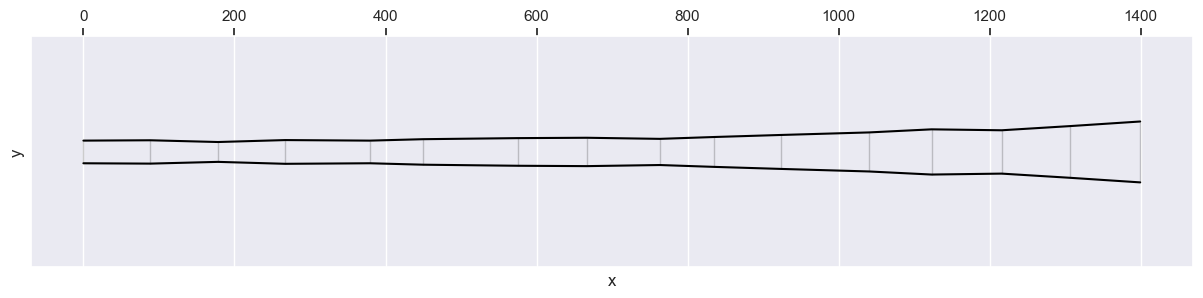

In [10]:
# shape

from cad.calc.parameters import MutationParameterSet, MutationParameter
from cad.ui.visualization import DidgeVisualizer
from cad.calc.mutation import ExploringMutator
import pandas as pd
import tqdm
import random

np.random.seed(0)
random.seed(0)
mutator = ExploringMutator()


class BlackEucaShape(MutationParameterSet):
    
    def __init__(self):
        
        MutationParameterSet.__init__(self)

        self.d1=30
        self.n_segments = 15

        self.add_param("length", 1380, 1400)
        self.add_param("bellsize", 77, 83)
        self.add_param("power", 1,2)
        
        for i in range(self.n_segments-1):
            self.add_param(f"delta_x{i}", -20, 20)
            self.add_param(f"delta_y{i}", 0.8, 1.2)
        

    def make_geo(self):
        length = self.get_value("length")
        bellsize = self.get_value("bellsize")

        x = length*np.arange(self.n_segments+1)/self.n_segments
    
        y= np.arange(self.n_segments+1)/self.n_segments
        p = self.get_value("power")
        y = np.power(y, p)
        y = np.power(y, p)
        y = np.power(y, p)
        y = self.d1 + y*(bellsize - self.d1)
        
        for i in range(1, self.n_segments-1):
            delta_x = self.get_value(f"delta_x{i}")
            delta_y = self.get_value(f"delta_y{i}")
            y[i] *= delta_y
            x[i] += delta_x
            x = sorted(x)
            
        geo = list(zip(x,y))
        
        return Geo(geo)

shape = BlackEucaShape()
for i in range(3):
    mutator.mutate(shape)
geo = shape.make_geo()
DidgeVisualizer.vis_didge(geo)

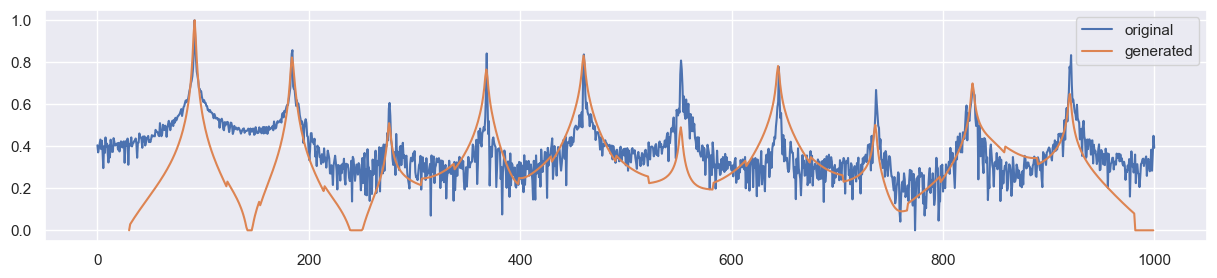

In [103]:

indir = "/Users/jane03/workspaces/music/didge/github-repo/evolutions/maveira2/results/report_1/"
infile = indir + "0_geo.txt"
maveira = json.load(open(infile, "r"))
#[[0.0, 32.0], [83.35332871777914, 35.0162328995634], [177.9648752136909, 34.82690089056204], [281.83166112126344, 29.124969714659077], [367.35680173872487, 29.01183093695966], [475.301155472401, 30.081015724957382], [532.6586686684653, 46.784454958915724], [620.365614379913, 51.31551058009397], [712.8954813604888, 38.05346860949759], [814.2715130217262, 48.75212765476513], [921.0838306416952, 65.51753708883814], [1024.98881282807, 61.88195136143321], [1091.417201565728, 65.42744180973494], [1203.11178631251, 81.20715408526168], [1280.731228759826, 84.57169980021843], [1372.2120308140995, 93.08226266864497]]

cadsd = Geo(maveira).get_cadsd().get_ground_spektrum()

ground_freqs = np.array(list(cadsd.keys()))
ground_vol = np.array(list(cadsd.values()))
ground_vol /= ground_vol.max()

infile = "didgeridoo-samples/wav_short/4.wav"
freq, spectrum = do_fft(infile)
spectrum = np.log2(spectrum)

spectrum -= spectrum.min()
spectrum = spectrum / np.max(spectrum)

plt.plot(freq, spectrum, label="original")
plt.plot(ground_freqs, ground_vol, label="generated")
plt.legend()


In [102]:
volumes=[]
files=[]
for f in sorted(os.listdir(indir)):
    if f[-4:] != ".txt":
        continue
    path = os.path.join(indir, f)
    geo = json.load(open(path, "r"))
    
    vol = 0
    for i in np.arange(1, len(geo)):
        length = geo[i][0] - geo[i-1][0]
        vol += geo[i-1][1] * length
        vol += length * (geo[i][1]-geo[i-1][1]) / 2 
    
    files.append(f)
    volumes.append(vol)

sorted(range(len(files)), key=lambda x : volumes[x])


[3, 0, 4, 1, 8, 2, 9, 5, 7, 6]